In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
import datetime
# import tensorflow as tf

Using TensorFlow backend.


In [26]:
fine_dust = pd.read_csv('data/fine_dust.csv', encoding = 'utf-8')
fine_dust.head()

,측정일자,권역명,측정소명,미세먼지(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm),year,month,day,date
0,20200419,도심권,중구,29,20,0.015,0.024,0.5,0.002,2020,4,19,2020-04-19
1,20200419,도심권,종로구,30,18,0.019,0.024,0.5,0.003,2020,4,19,2020-04-19
2,20200419,도심권,용산구,33,19,0.010,0.023,0.5,0.002,2020,4,19,2020-04-19
3,20200419,서북권,은평구,26,15,0.027,0.011,0.3,0.003,2020,4,19,2020-04-19
4,20200419,서북권,서대문구,33,21,0.026,0.013,0.5,0.002,2020,4,19,2020-04-19


In [27]:
fine_dust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9071 entries, 0 to 9070
Data columns (total 13 columns):
측정일자            9071 non-null int64
권역명             9071 non-null object
측정소명            9071 non-null object
미세먼지(㎍/㎥)       9071 non-null int64
초미세먼지(㎍/㎥)      9071 non-null int64
오존(ppm)         9071 non-null float64
이산화질소농도(ppm)    9071 non-null float64
일산화탄소농도(ppm)    9071 non-null float64
아황산가스농도(ppm)    9071 non-null float64
year            9071 non-null int64
month           9071 non-null int64
day             9071 non-null int64
date            9071 non-null object
dtypes: float64(4), int64(6), object(3)
memory usage: 921.4+ KB


In [28]:
del fine_dust['권역명']
del fine_dust['측정일자']
del fine_dust['year']
del fine_dust['month']
del fine_dust['day']
del fine_dust['오존(ppm)']
del fine_dust['아황산가스농도(ppm)']
del fine_dust['이산화질소농도(ppm)']
del fine_dust['일산화탄소농도(ppm)']
del fine_dust['미세먼지(㎍/㎥)']

In [29]:
pd.to_datetime(fine_dust['date'])

0      2020-04-19
1      2020-04-19
2      2020-04-19
3      2020-04-19
4      2020-04-19
          ...    
9066   2019-04-19
9067   2019-04-19
9068   2019-04-19
9069   2019-04-19
9070   2019-04-19
Name: date, Length: 9071, dtype: datetime64[ns]

In [30]:
fine_dust = fine_dust.sort_values(by='date', ascending=True)
fine_dust

,측정소명,초미세먼지(㎍/㎥),date
9070,강동구,16,2019-04-19
9046,중구,18,2019-04-19
9047,종로구,16,2019-04-19
9048,용산구,16,2019-04-19
9049,은평구,22,2019-04-19
...,...,...,...
22,서초구,33,2020-04-19
23,송파구,19,2020-04-19
24,강동구,21,2020-04-19
12,강북구,19,2020-04-19


In [31]:
fine_dust = pd.pivot_table(fine_dust, index = ['date'], columns = ['측정소명'], values = ['초미세먼지(㎍/㎥)'])
fine_dust

초미세먼지(㎍/㎥)                                                        \
측정소명              강남구   강동구   강북구   강서구   관악구   광진구   구로구   금천구   노원구   도봉구   
date                                                                          
2019-04-19       19.0  16.0  16.0  22.0  33.0  27.0  25.0  20.0  19.0  22.0   
2019-04-20       21.0  21.0  21.0  22.0  28.0  28.0  30.0  21.0  22.0  23.0   
2019-04-21       19.0  18.0  17.0  22.0  37.0  34.0  29.0  20.0  19.0  23.0   
2019-04-22       33.0  31.0  27.0  35.0  56.0  51.0  57.0  30.0  29.0  41.0   
2019-04-23       41.0  39.0  35.0  45.0  53.0  52.0  64.0  34.0  41.0  41.0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
2020-04-15       39.0  41.0  38.0  37.0  32.0  40.0  37.0  35.0  39.0  35.0   
2020-04-16       31.0  31.0  31.0  29.0  26.0  28.0  25.0  29.0  31.0  28.0   
2020-04-17       20.0  18.0  21.0  21.0  18.0  19.0  40.0  21.0  20.0  20.0   
2020-04-18       14.0  13.0  11.0  13.0  12.0  13.0  19.0  13.0  11.0  11.0   
2020-04-19       21.0  21.0  19.0  20.0  17.0  21.0  31.0  17.0  19.0  20.0   

            ...                                                              
측정소명        ...   성동구   성북구   송파구   양천구  영등포구   용산구   은평구   종로구    중구   중랑구  
date        ...                                                              
2019-04-19  ...  26.0  16.0  28.0  22.0  39.0  16.0  22.0  16.0  18.0  17.0  
2019-04-20  ...  25.0  21.0  27.0  22.0  32.0  19.0  25.0  19.0  19.0  21.0  
2019-04-21  ...  31.0  18.0  32.0  21.0  37.0  18.0  27.0  17.0  16.0  20.0  
2019-04-22  ...  47.0  27.0  46.0  35.0  56.0  30.0  38.0  27.0  29.0  32.0  
2019-04-23  ...  48.0  39.0  50.0  47.0  63.0  40.0  39.0  34.0  34.0  40.0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
2020-04-15  ...  38.0  35.0  36.0  39.0  36.0  37.0  36.0  38.0  41.0  35.0  
2020-04-16  ...  28.0  28.0  30.0  29.0  27.0  28.0  27.0  30.0  32.0  27.0  
2020-04-17  ...  19.0  20.0  19.0  21.0  20.0  20.0  20.0  21.0  22.0  18.0  
2020-04-18  ...  13.0  11.0  12.0  12.0  11.0  12.0  15.0  13.0  13.0  11.0  
2020-04-19  ...  20.0  19.0  19.0  20.0  19.0  19.0  15.0  18.0  20.0  18.0  

[363 rows x 25 columns]

In [32]:
fine_dust[fine_dust == 0] = 0.01

In [33]:
fine_dust_gangnam = fine_dust.iloc[:,0].values

In [34]:
# create windows
seq_len = 40
sequence_length = seq_len +1

result = []
for index in range(len(fine_dust_gangnam) - sequence_length):
    result.append(fine_dust_gangnam[index:index+sequence_length])

In [35]:
result

[array([19., 21., 19., 33., 41., 33., 16.,  4.,  8., 10., 13., 18., 24.,
        15., 23., 54., 38., 10., 15., 19., 20., 29., 35., 33., 34., 30.,
        43., 41., 38., 16.,  8., 10., 14., 22., 37., 47., 53., 22., 12.,
         5., 19.]),
 array([21., 19., 33., 41., 33., 16.,  4.,  8., 10., 13., 18., 24., 15.,
        23., 54., 38., 10., 15., 19., 20., 29., 35., 33., 34., 30., 43.,
        41., 38., 16.,  8., 10., 14., 22., 37., 47., 53., 22., 12.,  5.,
        19., 21.]),
 array([19., 33., 41., 33., 16.,  4.,  8., 10., 13., 18., 24., 15., 23.,
        54., 38., 10., 15., 19., 20., 29., 35., 33., 34., 30., 43., 41.,
        38., 16.,  8., 10., 14., 22., 37., 47., 53., 22., 12.,  5., 19.,
        21.,  9.]),
 array([33., 41., 33., 16.,  4.,  8., 10., 13., 18., 24., 15., 23., 54.,
        38., 10., 15., 19., 20., 29., 35., 33., 34., 30., 43., 41., 38.,
        16.,  8., 10., 14., 22., 37., 47., 53., 22., 12.,  5., 19., 21.,
         9., 18.]),
 array([41., 33., 16.,  4.,  8., 10., 13., 1

In [36]:
# normalize data
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) -1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0]*0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((290, 40, 1), (32, 40, 1))

In [38]:
result

array([[ 0.        , -0.8       , -0.6       , ...,  0.1       ,
        -0.03333333, -0.33333333],
       [ 0.        , -0.28      , -0.56      , ...,  0.08      ,
        -0.28      , -0.88      ],
       [ 0.        ,  0.22916667,  0.0625    , ..., -0.39583333,
        -0.22916667, -0.16666667],
       ...,
       [ 0.        ,  0.13513514,  0.16216216, ..., -0.24324324,
         0.05405405, -0.16216216],
       [ 0.        ,  0.02380952, -0.28571429, ..., -0.07142857,
        -0.26190476, -0.52380952],
       [ 0.        , -0.30232558, -0.76744186, ..., -0.27906977,
        -0.53488372, -0.6744186 ]])

In [39]:
# build a model
model = Sequential()

model.add(LSTM(40, return_sequences=True, input_shape=(40,1)))

model.add(LSTM(50, return_sequences=False))

model.add(Dense(1, activation='linear')) # 활성화함수

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 40)            6720      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                18200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 24,971
Trainable params: 24,971
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Traing
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test), 
          batch_size=10, 
          epochs=20)

Train on 290 samples, validate on 32 samples
Epoch 1/20
290/290 [==============================] - 2s 8ms/step - loss: 31230.9709 - val_loss: 0.2521
Epoch 2/20
290/290 [==============================] - 1s 4ms/step - loss: 31041.4493 - val_loss: 0.3619
Epoch 3/20
290/290 [==============================] - 1s 4ms/step - loss: 30904.2256 - val_loss: 0.1824
Epoch 4/20
290/290 [==============================] - 1s 4ms/step - loss: 30815.6108 - val_loss: 0.2313
Epoch 5/20
290/290 [==============================] - 1s 4ms/step - loss: 30749.0663 - val_loss: 0.1476
Epoch 6/20
290/290 [==============================] - 1s 4ms/step - loss: 30695.8145 - val_loss: 0.2199
Epoch 7/20
290/290 [==============================] - 1s 4ms/step - loss: 30656.4124 - val_loss: 0.3563
Epoch 8/20
290/290 [==============================] - 1s 4ms/step - loss: 30617.6506 - val_loss: 0.1958
Epoch 9/20
290/290 [==============================] - 1s 4ms/step - loss: 30580.3612 - val_loss: 0.4975
Epoch 10/20
290/290

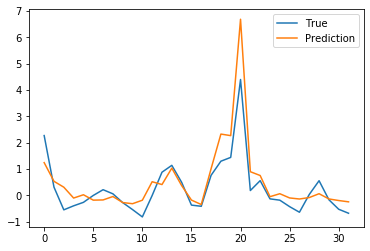

In [41]:
# prediction
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

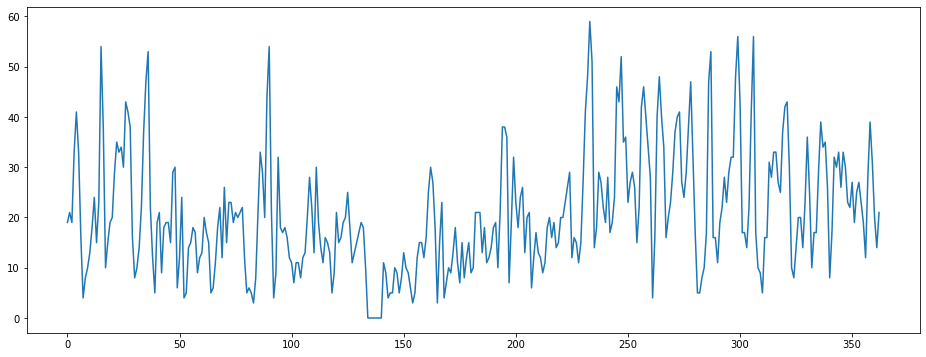

In [42]:
plt.figure(figsize=(16,6))
plt.plot(fine_dust_gangnam)
plt.show